# This notebook demonstrates how to set up and run Automatic Speech Recognition (ASR) and Speaker Diarization using NVIDIA NeMo. It covers the installation of dependencies, creation of a manifest file, and execution of diarization with ASR.

## Install Dependencies


In [ ]:
## Install dependencies
!pip install wget
!apt-get install -y sox libsndfile1 ffmpeg
!pip install text-unidecode

# ## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

## Install TorchAudio
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
!git clone https://github.com/NVIDIA/NeMo.git
!pip install  gdown
!pip install pyctcdecode
!pip install https://github.com/kpu/kenlm/archive/master.zip
#download language model
!gdown --id 1CwQw31kD1t0UuWMdRXUPyPYy8Y3cQRqR
#download ASR model
!gdown --id 1cvSeVujC5urRUY5Fmuo-SSfACsJ4TCTa

## Imports

In [ ]:
import nemo.collections.asr as nemo_asr
import numpy as np
from IPython.display import Audio, display
import librosa
import os
import wget
import matplotlib.pyplot as plt

import nemo
import glob

import pprint
os.environ['HYDRA_FULL_ERROR'] = '1'
os.environ['OC_CAUSE'] = '1'
pp = pprint.PrettyPrinter(indent=4)

## Create Path Files to Diarize Manifest Script

In [ ]:
%%writefile  pathfiles_to_diarize_manifest.py
# Copyright (c) 2022, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import random

from nemo.collections.asr.parts.utils.manifest_utils import create_manifest

random.seed(42)

"""
This script creates manifest file for speaker diarization inference purposes.
Useful to get manifest when you have list of audio files and optionally rttm and uem files for evaluation

Note: make sure basename for each file is unique and rttm files also has the corresponding base name for mapping
"""


def main(
    wav_path, text_path=None, rttm_path=None, uem_path=None, ctm_path=None, manifest_filepath=None, add_duration=False
):
    create_manifest(
        wav_path,
        manifest_filepath,
        text_path=text_path,
        rttm_path=rttm_path,
        uem_path=uem_path,
        ctm_path=ctm_path,
        add_duration=add_duration,
    )


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--paths2audio_files", help="path to text file containing list of audio files", type=str, required=True
    )
    parser.add_argument("--paths2txt_files", help="path to text file containing list of transcription files", type=str)
    parser.add_argument("--paths2rttm_files", help="path to text file containing list of rttm files", type=str)
    parser.add_argument("--paths2uem_files", help="path to uem files", type=str)
    parser.add_argument("--paths2ctm_files", help="path to ctm files", type=str)
    parser.add_argument("--manifest_filepath", help="path to output manifest file", type=str, required=True)
    parser.add_argument(
        "--add_duration", help="add duration of audio files to output manifest files.", action='store_true',
    )
    args = parser.parse_args()

    main(
        args.paths2audio_files,
        args.paths2txt_files,
        args.paths2rttm_files,
        args.paths2uem_files,
        args.paths2ctm_files,
        args.manifest_filepath,
        args.add_duration,
    )


In [ ]:
!touch audio_files.txt

## Create List of Audio Files

In [ ]:
import os

wav_directory = '/kaggle/input/diarization-test/wavs'  # Directory containing your WAV files
output_file = '/kaggle/working/audio_files.txt'  # Text file to save the list of audio files

with open(output_file, 'w') as f:
    for wav_file in os.listdir(wav_directory):
        if wav_file.endswith('.wav'):
            f.write(os.path.join(wav_directory, wav_file) + '\n')


## Run the Manifest Creation Script

In [ ]:
!python /kaggle/working/pathfiles_to_diarize_manifest.py --paths2audio_files audio_files.txt --manifest_filepath output_manifest.json


In [ ]:
mkdir config

## Configuration File for Diarization with ASR

In [ ]:

%%writefile /kaggle/working/config/diar_infer_meeting.yaml
# bestttttt
# This YAML file is created for all types of offline speaker diarization inference tasks in `<NeMo git root>/example/speaker_tasks/diarization` folder.
# The inference parameters for VAD, speaker embedding extractor, clustering module, MSDD module, ASR decoder are all included in this YAML file. 
# All the keys under `diarizer` key (`vad`, `speaker_embeddings`, `clustering`, `msdd_model`, `asr`) can be selectively used for its own purpose and also can be ignored if the module is not used.
# The configurations in this YAML file is suitable for telephone recordings involving 2~8 speakers in a session and may not show the best performance on the other types of acoustic conditions or dialogues.
# An example line in an input manifest file (`.json` format):
# {"audio_filepath": "/path/to/audio_file", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": "/path/to/rttm/file", "uem_filepath": "/path/to/uem/file"}
name: &name "ClusterDiarizer"

num_workers: 1
sample_rate: 16000
batch_size: 64
device: null # can specify a specific device, i.e: cuda:1 (default cuda if cuda available, else cpu)
verbose: True # enable additional logging

diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: False # If True, uses RTTM files provided in the manifest file to get speech activity (VAD) timestamps
  collar: 0.25 # Collar value for scoring
  ignore_overlap: True # Consider or ignore overlap segments while scoring

  vad:
    model_path: vad_multilingual_marblenet # .nemo local model path or pretrained VAD model name 
    external_vad_manifest: null # This option is provided to use external vad and provide its speech activity labels for speaker embeddings extraction. Only one of model_path or external_vad_manifest should be set

    parameters: # Tuned parameters for CH109 (using the 11 multi-speaker sessions as dev set) 
      window_length_in_sec: 0.15  # Window length in sec for VAD context input 
      shift_length_in_sec: 0.01 # Shift length in sec for generate frame level VAD prediction
      smoothing: "median" # False or type of smoothing method (eg: median)
      overlap: 0.5 # Overlap ratio for overlapped mean/median smoothing filter
      onset: 0.1 # Onset threshold for detecting the beginning and end of a speech 
      offset: 0.1 # Offset threshold for detecting the end of a speech
      pad_onset: 0.1 # Adding durations before each speech segment 
      pad_offset: 0 # Adding durations after each speech segment 
      min_duration_on: 0 # Threshold for small non_speech deletion
      min_duration_off: 0.2 # Threshold for short speech segment deletion
      filter_speech_first: True 

  speaker_embeddings:
    model_path: titanet_large # .nemo local model path or pretrained model name (titanet_large, ecapa_tdnn or speakerverification_speakernet)
    parameters:
      window_length_in_sec: [1.5,1.25,1.0,0.75,0.5] # Window length(s) in sec (floating-point number). either a number or a list. ex) 1.5 or [1.5,1.0,0.5]
      shift_length_in_sec: [0.75,0.625,0.5,0.375,0.25] # Shift length(s) in sec (floating-point number). either a number or a list. ex) 0.75 or [0.75,0.5,0.25]
      multiscale_weights: [1,1,1,1,1] # Weight for each scale. should be null (for single scale) or a list matched with window/shift scale count. ex) [0.33,0.33,0.33]
      save_embeddings: True # If True, save speaker embeddings in pickle format. This should be True if clustering result is used for other models, such as `msdd_model`.
  
  clustering: 
    parameters:
      oracle_num_speakers: False # If True, use num of speakers value provided in manifest file.
      max_num_speakers: 8 # Max number of speakers for each recording. If an oracle number of speakers is passed, this value is ignored.
      enhanced_count_thres: 80 # If the number of segments is lower than this number, enhanced speaker counting is activated.
      max_rp_threshold: 0.25 # Determines the range of p-value search: 0 < p <= max_rp_threshold. 
      sparse_search_volume: 30 # The higher the number, the more values will be examined with more time. 
      maj_vote_spk_count: False  # If True, take a majority vote on multiple p-values to estimate the number of speakers.
      chunk_cluster_count: 50 # Number of forced clusters (overclustering) per unit chunk in long-form audio clustering.
      embeddings_per_chunk: 10000 # Number of embeddings in each chunk for long-form audio clustering. Adjust based on GPU memory capacity. (default: 10000, approximately 40 mins of audio) 
  
  msdd_model:
    model_path: diar_msdd_meeting # .nemo local model path or pretrained model name for multiscale diarization decoder (MSDD)
    parameters:
      use_speaker_model_from_ckpt: True # If True, use speaker embedding model in checkpoint. If False, the provided speaker embedding model in config will be used.
      infer_batch_size: 25 # Batch size for MSDD inference. 
      sigmoid_threshold: [0.7] # Sigmoid threshold for generating binarized speaker labels. The smaller the more generous on detecting overlaps.
      seq_eval_mode: False # If True, use oracle number of speaker and evaluate F1 score for the given speaker sequences. Default is False.
      split_infer: True # If True, break the input audio clip to short sequences and calculate cluster average embeddings for inference.
      diar_window_length: 50 # The length of split short sequence when split_infer is True.
      overlap_infer_spk_limit: 5 # If the estimated number of speakers are larger than this number, overlap speech is not estimated.
  
  asr:
    model_path: stt_en_conformer_ctc_small # Provide NGC cloud ASR model name. stt_en_conformer_ctc_* models are recommended for diarization purposes.
    parameters:
      asr_based_vad: False # if True, speech segmentation for diarization is based on word-timestamps from ASR inference.
      asr_based_vad_threshold: 1.0 # Threshold (in sec) that caps the gap between two words when generating VAD timestamps using ASR based VAD.
      asr_batch_size: null # Batch size can be dependent on each ASR model. Default batch sizes are applied if set to null.
      decoder_delay_in_sec: null # Native decoder delay. null is recommended to use the default values for each ASR model.
      word_ts_anchor_offset: null # Offset to set a reference point from the start of the word. Recommended range of values is [-0.05  0.2]. 
      word_ts_anchor_pos: "start" # Select which part of the word timestamp we want to use. The options are: 'start', 'end', 'mid'.
      fix_word_ts_with_VAD: False # Fix the word timestamp using VAD output. You must provide a VAD model to use this feature.
      colored_text: False # If True, use colored text to distinguish speakers in the output transcript.
      print_time: True # If True, the start and end time of each speaker turn is printed in the output transcript.
      break_lines: False # If True, the output transcript breaks the line to fix the line width (default is 90 chars)
    
    ctc_decoder_parameters: # Optional beam search decoder (pyctcdecode)
      pretrained_language_model: null # KenLM model file: .arpa model file or .bin binary file.
      beam_width: 32
      alpha: 0.5
      beta: 2.5

    realigning_lm_parameters: # Experimental feature
      arpa_language_model: null # Provide a KenLM language model in .arpa format.
      min_number_of_words: 3 # Min number of words for the left context.
      max_number_of_words: 10 # Max number of words for the right context.
      logprob_diff_threshold: 1.2  # The threshold for the difference between two log probability values from two hypotheses.

In [ ]:
%%writefile offline_diar_with_asr_infer.py
# Copyright (c) 2021, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


from omegaconf import OmegaConf

from nemo.collections.asr.parts.utils.decoder_timestamps_utils import ASRDecoderTimeStamps
from nemo.collections.asr.parts.utils.diarization_utils import OfflineDiarWithASR
from nemo.core.config import hydra_runner
from nemo.utils import logging


"""
This script demonstrates how to run offline speaker diarization with asr.
Usage:
python offline_diar_with_asr_infer.py \
    diarizer.manifest_filepath=<path to manifest file> \
    diarizer.out_dir='demo_asr_output' \
    diarizer.speaker_embeddings.model_path=<pretrained modelname or path to .nemo> \
    diarizer.asr.model_path=<pretrained modelname or path to .nemo> \
    diarizer.asr.parameters.asr_based_vad=True \
    diarizer.speaker_embeddings.parameters.save_embeddings=False

Check out whole parameters in ./conf/offline_diarization_with_asr.yaml and their meanings.
For details, have a look at <NeMo_git_root>/tutorials/speaker_tasks/Speaker_Diarization_Inference.ipynb
Currently, the following NGC models are supported:

    stt_en_quartznet15x5
    stt_en_citrinet*
    stt_en_conformer_ctc*

"""


@hydra_runner(config_path="/kaggle/working/config", config_name="diar_infer_meeting.yaml")
def main(cfg):

    logging.info(f'Hydra config: {OmegaConf.to_yaml(cfg)}')

    # ASR inference for words and word timestamps
    asr_decoder_ts = ASRDecoderTimeStamps(cfg.diarizer)
    asr_model = asr_decoder_ts.set_asr_model()
    word_hyp, word_ts_hyp = asr_decoder_ts.run_ASR(asr_model)

    # Create a class instance for matching ASR and diarization results
    asr_diar_offline = OfflineDiarWithASR(cfg.diarizer)
    asr_diar_offline.word_ts_anchor_offset = asr_decoder_ts.word_ts_anchor_offset

    # Diarization inference for speaker labels
    diar_hyp, diar_score = asr_diar_offline.run_diarization(cfg, word_ts_hyp)
    trans_info_dict = asr_diar_offline.get_transcript_with_speaker_labels(diar_hyp, word_hyp, word_ts_hyp)

    # If RTTM is provided and DER evaluation
    if diar_score is not None:
        # Get session-level diarization error rate and speaker counting error
        der_results = OfflineDiarWithASR.gather_eval_results(
            diar_score=diar_score,
            audio_rttm_map_dict=asr_diar_offline.AUDIO_RTTM_MAP,
            trans_info_dict=trans_info_dict,
            root_path=asr_diar_offline.root_path,
        )

        # Calculate WER and cpWER if reference CTM files exist
        wer_results = OfflineDiarWithASR.evaluate(
            hyp_trans_info_dict=trans_info_dict,
            audio_file_list=asr_diar_offline.audio_file_list,
            ref_ctm_file_list=asr_diar_offline.ctm_file_list,
        )

        # Print average DER, WER and cpWER
        OfflineDiarWithASR.print_errors(der_results=der_results, wer_results=wer_results)

        # Save detailed session-level evaluation results in `root_path`.
        OfflineDiarWithASR.write_session_level_result_in_csv(
            der_results=der_results,
            wer_results=wer_results,
            root_path=asr_diar_offline.root_path,
            csv_columns=asr_diar_offline.csv_columns,
        )


if __name__ == '__main__':
    main()


## test sample

In [ ]:
%%writefile /kaggle/working/2_sample_manifest.json
{"audio_filepath": "/kaggle/input/diarization-test/wavs/audio_sample_20.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": null, "uem_filepath": null, "ctm_filepath": null}
{"audio_filepath": "/kaggle/input/diarization-test/wavs/audio_sample_117.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": null, "rttm_filepath": null, "uem_filepath": null, "ctm_filepath": null}


In [ ]:
#just for test
!python /kaggle/working/offline_diar_with_asr_infer.py \
    diarizer.manifest_filepath="/kaggle/working/2_sample_manifest.json" \
    diarizer.out_dir='demo_asr_output' \
    diarizer.asr.model_path=stt_en_conformer_ctc_small\
    #diarizer.asr.model_path="/kaggle/working/final_asr_model.nemo"\
    diarizer.asr.parameters.asr_based_vad=True \
    diarizer.asr.ctc_decoder_parameters.pretrained_language_model="/kaggle/working/kenlm_model.binary" \
    diarizer.speaker_embeddings.parameters.save_embeddings=False

## Replace our ASR model with stt_en_conformer_ctc_small model

In [ ]:
rm /root/.cache/torch/NeMo/NeMo_2.0.0rc2/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55/stt_en_conformer_ctc_small.nemo

In [ ]:
ls /root/.cache/torch/NeMo/NeMo_2.0.0rc2/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55

In [ ]:
cp /kaggle/working/stt_en_conformer_ctc_small.nemo /root/.cache/torch/NeMo/NeMo_2.0.0rc2/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55

In [ ]:
ls /root/.cache/torch/NeMo/NeMo_2.0.0rc2/stt_en_conformer_ctc_small/5d2d8e5b2b5adb8f5091363c6ba19c55

In [ ]:
cd /kaggle/working/

# Run Diarization

In [ ]:
#Generate json files from wav files
!python /kaggle/working/offline_diar_with_asr_infer.py \
    diarizer.manifest_filepath="/kaggle/working/output_manifest.json" \
    diarizer.out_dir='demo_asr_output' \
    diarizer.asr.model_path=stt_en_conformer_ctc_small\
    #diarizer.asr.model_path="/kaggle/working/final_asr_model.nemo"\
    diarizer.asr.parameters.asr_based_vad=True \
    diarizer.asr.ctc_decoder_parameters.pretrained_language_model="/kaggle/working/kenlm_model.binary" \
    diarizer.speaker_embeddings.parameters.save_embeddings=False

## Remove _gecko.json file to work on audio_sample_.json files only

In [ ]:
import os
import glob

# Specify the directory
directory = '/kaggle/working/demo_asr_output/pred_rttms'

# Get a list of all files in the directory that end with _gecko.json
files_to_remove = glob.glob(os.path.join(directory, '*_gecko.json'))

# Loop through the list and remove each file
for file_path in files_to_remove:
    try:
        os.remove(file_path)
        print(f"Removed: {file_path}")
    except OSError as e:
        print(f"Error: {file_path} : {e.strerror}")

print("All _gecko.json files have been removed.")


In [ ]:
!mkdir final_json_files

## Handel json files to match this sample struture 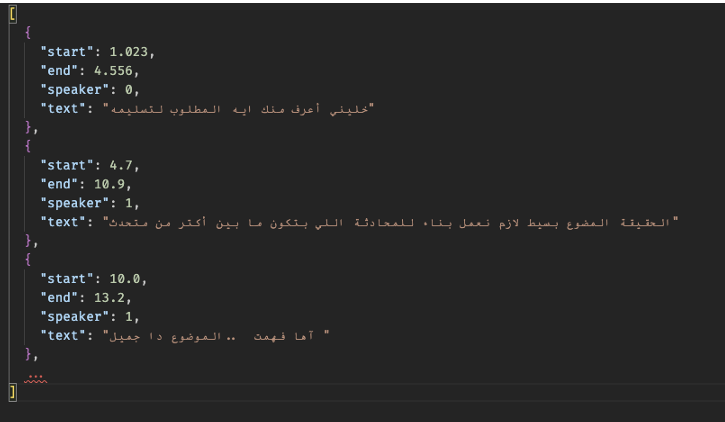

In [ ]:
import json
import os

# Source and destination directories
source_dir = '/kaggle/working/demo_asr_output/pred_rttms'
destination_dir = '/kaggle/working/final_json_files'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Function to convert the data to the desired format
def convert_data(original_data):
    updated_data = []
    speaker_map = {}
    next_speaker_id = 0
    
    for sentence in original_data['sentences']:
        original_speaker = int(sentence['speaker'].replace('speaker_', ''))
        
        if original_speaker not in speaker_map:
            speaker_map[original_speaker] = next_speaker_id
            next_speaker_id += 1
        
        new_speaker_id = speaker_map[original_speaker]
        
        updated_data.append({
            "start": float(sentence['start_time']),
            "end": float(sentence['end_time']),
            "speaker": new_speaker_id,
            "text": sentence['text']
        })
    return updated_data

# Process all JSON files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith('.json'):
        file_path = os.path.join(source_dir, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # Update the data
        updated_data = convert_data(data)
        
        # Save the updated data to the destination directory
        new_file_path = os.path.join(destination_dir, filename)
        with open(new_file_path, 'w', encoding='utf-8') as file:
            json.dump(updated_data, file, ensure_ascii=False, indent=4)
        
        print(f"Processed and saved: {filename}")

print("All files have been updated and saved.")
